#Importing libraries


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import KFold
import random
import statistics

In [36]:
tf.__version__

'2.2.0'

# Loading MNIST digits dataset

In [37]:
def import_dataset():
  # import mnist dataset
  (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
  print("Training set: X=%s, y=%s" % (X_train.shape, y_train.shape))
  print("Test set: X=%s, y=%s" % (X_test.shape, y_test.shape))

  # show several images loaded from mnist
  for i in range(1, 13):
      plt.subplot(3, 4, i)
      plt.imshow(X_train[i], cmap = 'Greys')
  plt.show()

  # Reshape the array into a single color channel as the images are grayscale
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
  X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

  # Using one hot encoding to class elements (y)
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
  # from sklearn.preprocessing import OneHotEncoder
  # enc = OneHotEncoder()
  # y_train = enc.fit_transform(y_train)
  # y_test = enc.fit_transform(y_test)
  
  return X_train, y_train, X_test, y_test

# Preparing pixel data (scaling)

In [38]:
def image_scaling(img):
  # normalizing pixel data i.e making the pixel values' range [0, 1]

  # changing unsigned int to float type
  img = img.astype('float')

  # deviding by the maximum value
  img = img / 255.0
  
  return img

#Composing the CNN

In [39]:
def build_cnn():
  # Initializing CNN
  cnn = tf.keras.models.Sequential()

  # Convolution
  cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = (28, 28, 1)))
  
  # Pooling
  cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))

  # Adding a second convolutional layer
  cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu'))
  cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))

  # Fulattening
  cnn.add(tf.keras.layers.Flatten())

  # Full Connection
  cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
  
  # Batch Normalization
  cnn.add(tf.keras.layers.BatchNormalization())
  
  # Output Layer
  cnn.add(tf.keras.layers.Dense(units = 10, activation = 'softmax'))

  # Compiling the CNN
  cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

  return cnn

# Evaluating the CNN model using K-fold Cross Validation

In [40]:
def kf_evaluating_CNN(X, y, n_splits):
  acc_scores, loss_scores, model_histories = list(), list(), list()
  kf = KFold(n_splits = n_splits, shuffle = True, random_state = 0)
  for train_index, test_index in kf.split(X):    
    # create train and test set for a fold
    X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
    
    # build cnn model
    cnn = build_cnn()

    # fit the model
    model_history = cnn.fit(x = X_train, y = y_train, batch_size = 32, epochs = 10, validation_data = (X_test, y_test), verbose = 0)

    # evaluate the model
    loss, acc = cnn.evaluate(X_test, y_test)
    print('accuracy: {:5f} %'.format(acc*100))
    # record evaluation into lists
    acc_scores.append(acc)
    loss_scores.append(loss)
    model_histories.append(model_history)
    
  return acc_scores, loss_scores, model_histories

  


# Show the evaluation results

In [41]:
def evaluation_results(acc_scores, loss_scores, model_histories):
  # calculate the mean and standard deviation of accuracies from k-fold
  print("Accuracy Average: {:.5} %".format(statistics.mean(acc_scores)))
  print("Accuracy Standard Deviation: {:.5} %".format(statistics.pstdev(acc_scores)))
  # calculate the mean and standard deviation of losses from k-fold
  print("Loss Average: {:.5} %".format(statistics.mean(loss_scores)))
  print("Loss Standard Deviation: {:.5} %".format(statistics.pstdev(loss_scores)))

  # set the size of plot frame
  plt.figure(figsize = (30, 20))

  # plot boxplot of accuracy and losses
  plt.subplot(2, 2, 1)
  plt.boxplot(acc_scores)
  plt.title('Accuracy Boxplot')
  plt.subplot(2, 2, 2)
  plt.title('Cross Entropy Loss Boxplot')
  plt.boxplot(loss_scores)

  # plot accuracies and losses lines for each fold
  # repeate plotting for each fold
  for i in range(len(model_histories)):
    # extract values from cnn training history
    loss = model_histories[i].history['loss']
    val_loss =  model_histories[i].history['val_loss']
    accuracy = model_histories[i].history['accuracy']
    val_accuracy = model_histories[i].history['val_accuracy']

    # create a list which has the order of epochs corresponding to the index number
    epochs = list(range(1, len(loss)+1))

    # plotting accuracy
    plt.subplot(2, 2, 3)
    # when i = 0, set all plot parameters. Especially for creating only one legend for all accuracy lines
    if i == 0:
      plt.plot(epochs, accuracy, color = 'red')
      line1, = plt.plot(epochs, accuracy, color = 'red')
      line1.set_label('Training Accuracy')
      plt.plot(epochs, val_accuracy, color = 'blue')
      line2, = plt.plot(epochs, val_accuracy, color = 'blue')
      line2.set_label('Test Accuracy')
      plt.legend()
      plt.title('Accuracy')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
    else:
      plt.plot(epochs, accuracy, color = 'red')
      plt.plot(epochs, val_accuracy, color = 'blue')

    # plotting loss
    plt.subplot(2, 2, 4)
    # when i = 0, set all plot parameters. especially for creating only one legend for all loss lines
    if i == 0:
      line3, = plt.plot(epochs, loss, color = 'red')
      line3.set_label('training loss')
      line4, = plt.plot(epochs, val_loss, color = 'blue')
      line4.set_label('test loss')
      plt.legend()
      plt.title('Cross Entropy Loss')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
    else:
      plt.plot(epochs, loss, color = 'red')
      plt.plot(epochs, val_loss, color = 'blue')
  plt.show()
     
    


# Training the CNN

In [42]:
def training_cnn(X_train, y_train, X_test, y_test):    
    # build cnn model
    cnn = build_cnn()

    # fit the model
    cnn.fit(x = X_train, y = y_train, batch_size = 32, epochs = 10, validation_data = (X_test, y_test))

    return cnn

# Making a single prediction

In [43]:
def single_prediction(model, X_test, y_test):
  # generate random number choose a random image from test set
  rnd = random.randint(0, 10000)

  # reverse array to the original scale image
  img = X_test[rnd] * 255.0
  img = img.astype('int')
  img = img.reshape(28, 28)

  # show the randomly selected image
  plt.imshow(img, cmap = 'Greys')

  # increase the dimention of the array for batch index as we trained the model with the shape (batch index, height, width, channel)
  results = model.predict(np.expand_dims(X_test[rnd], axis = 0))

  # choose the index of the biggest probability
  max = np.amax(results)
  print("Prediction: {}".format(np.where(results == max)[1][0]))

  # get the indices of the target value 
  print("Answer: {}".format(np.argmax(y_test[rnd])))

# Organizing functions

In [44]:
def main():
  # import dataset
  X_train, y_train, X_test, y_test = import_dataset()

  # scaling images (normalization) for ANN
  X_train, X_test = image_scaling(X_train), image_scaling(X_test)

  # set the number of the fold in k-fold cross validation
  num_kf = 5

  # evaluate the cnn model using k-fold cross validation 
  acc_scores, loss_scores, model_histories = kf_evaluating_CNN(X_train, y_train, num_kf)

  # show the evaluation results
  evaluation_results(acc_scores, loss_scores, model_histories)

  #train the cnn model on the training set
  cnn = training_cnn(X_train, y_train, X_test, y_test)

  # make a single prediction for a random image in test set
  single_prediction(cnn, X_test, y_test)

  return cnn, X_test, y_test


# Implement the whole model (starting point)

Training set: X=(60000, 28, 28), y=(60000,)
Test set: X=(10000, 28, 28), y=(10000,)


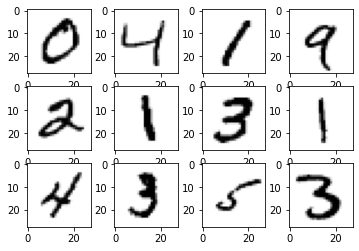

375/375 [==============================] - 3s 8ms/step - loss: 0.0397 - accuracy: 0.9899
accuracy: 98.991668 %
375/375 [==============================] - 3s 7ms/step - loss: 0.0453 - accuracy: 0.9882
accuracy: 98.816669 %
375/375 [==============================] - 3s 8ms/step - loss: 0.0465 - accuracy: 0.9893
accuracy: 98.933333 %
375/375 [==============================] - 3s 8ms/step - loss: 0.0349 - accuracy: 0.9909
accuracy: 99.091667 %
375/375 [==============================] - 3s 8ms/step - loss: 0.0315 - accuracy: 0.9911
accuracy: 99.108332 %
Accuracy Average: 0.98988 %
Accuracy Standard Deviation: 0.0010731 %
Loss Average: 0.039592 %
Loss Standard Deviation: 0.0057863 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


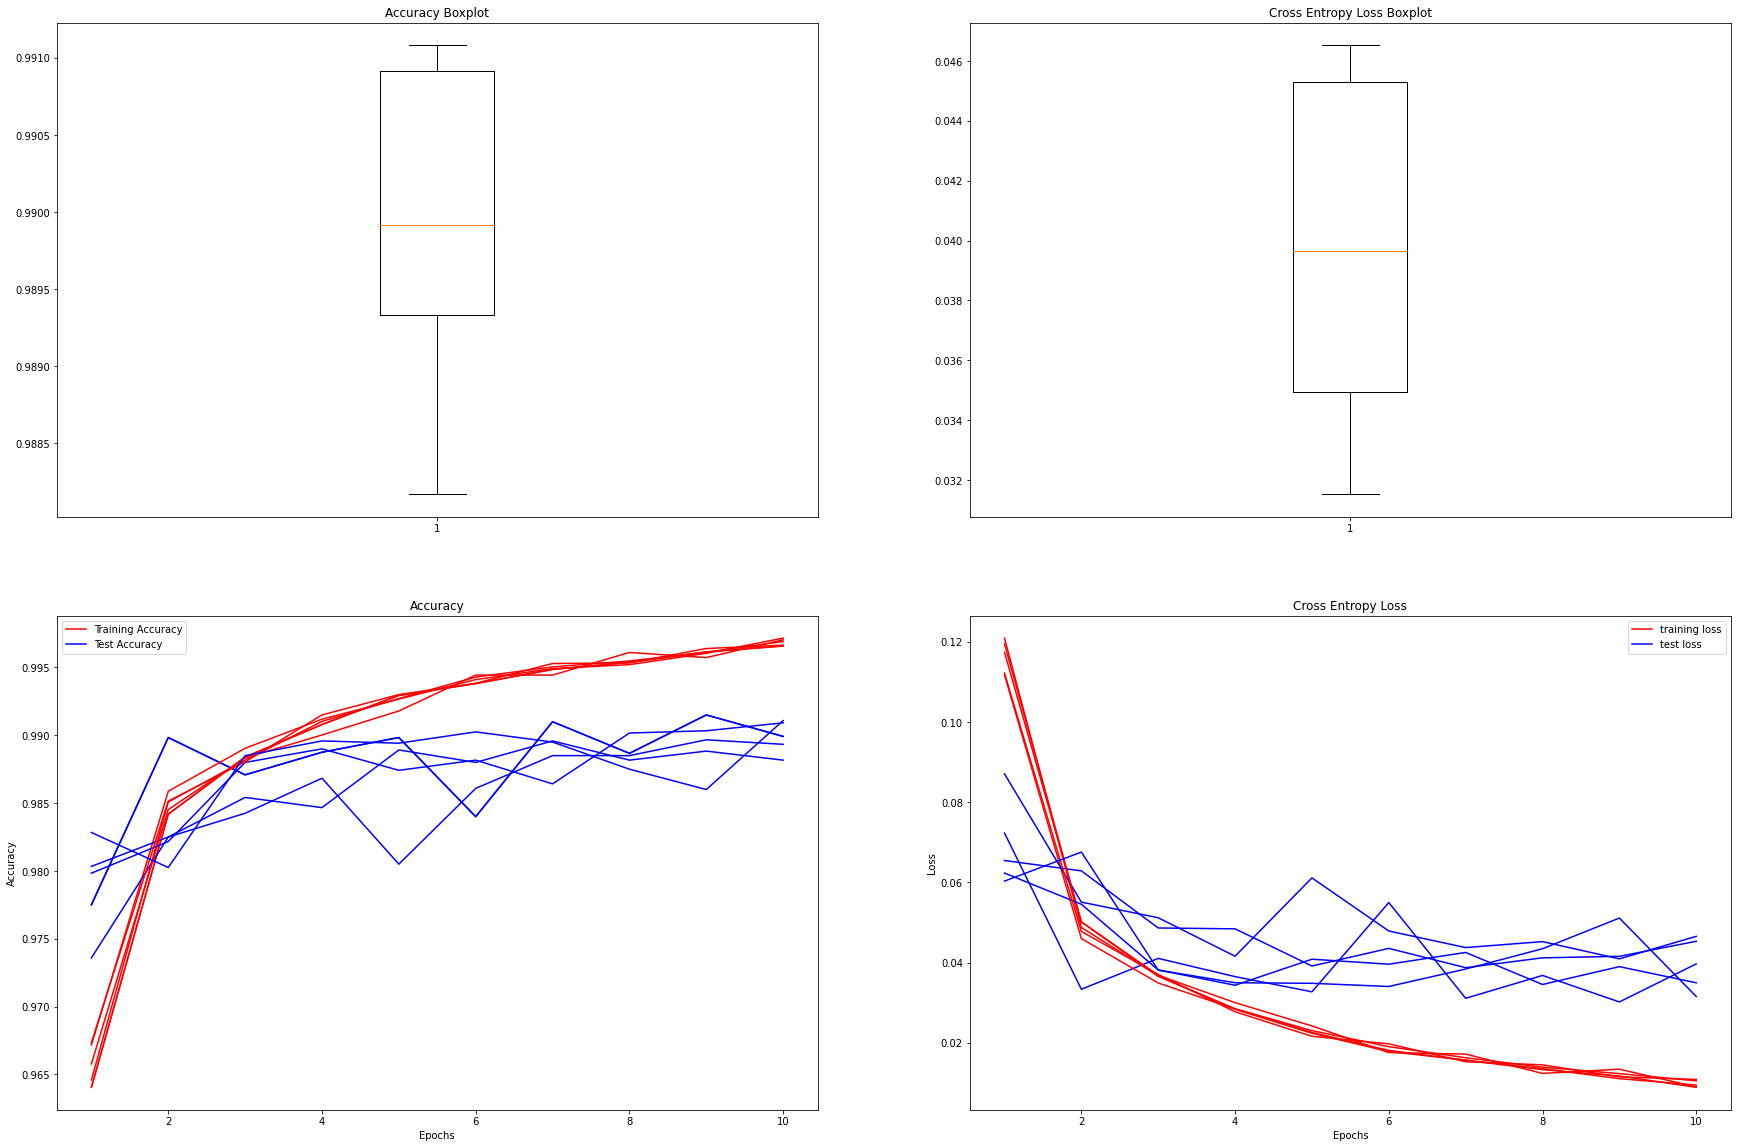

Epoch 1/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.1037 - accuracy: 0.9693 - val_loss: 0.0466 - val_accuracy: 0.9843
Epoch 2/10
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0456 - accuracy: 0.9854 - val_loss: 0.0443 - val_accuracy: 0.9845
Epoch 3/10
1875/1875 [==============================] - 42s 23ms/step - loss: 0.0334 - accuracy: 0.9898 - val_loss: 0.0351 - val_accuracy: 0.9883
Epoch 4/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0252 - accuracy: 0.9917 - val_loss: 0.0353 - val_accuracy: 0.9892
Epoch 5/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0217 - accuracy: 0.9926 - val_loss: 0.0343 - val_accuracy: 0.9887
Epoch 6/10
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0183 - accuracy: 0.9941 - val_loss: 0.0392 - val_accuracy: 0.9896
Epoch 7/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0153 - accuracy: 0.9949 - val_loss: 0.0289 -

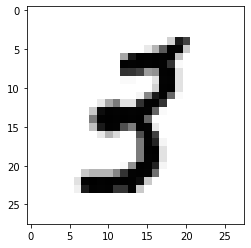

In [45]:
cnn, X_test, y_test = main()

## Make a single prediction

Prediction: 1
Answer: 1


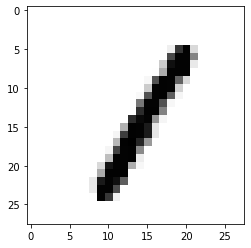

In [46]:
single_prediction(cnn, X_test, y_test)